<a href="https://colab.research.google.com/github/ocaelen/intro_deeplearning/blob/main/simple_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

import random
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import OneHotEncoder

In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Scale images variables in [0, 1]
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

# shape (60000, 28, 28) -> (60000, 28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

# shape (60000,) -> (60000, 1)
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)


# output to one hot encoding
enc = OneHotEncoder(sparse=False)
y_train_ohe = enc.fit_transform(y_train)
y_test_ohe = enc.transform(y_test)

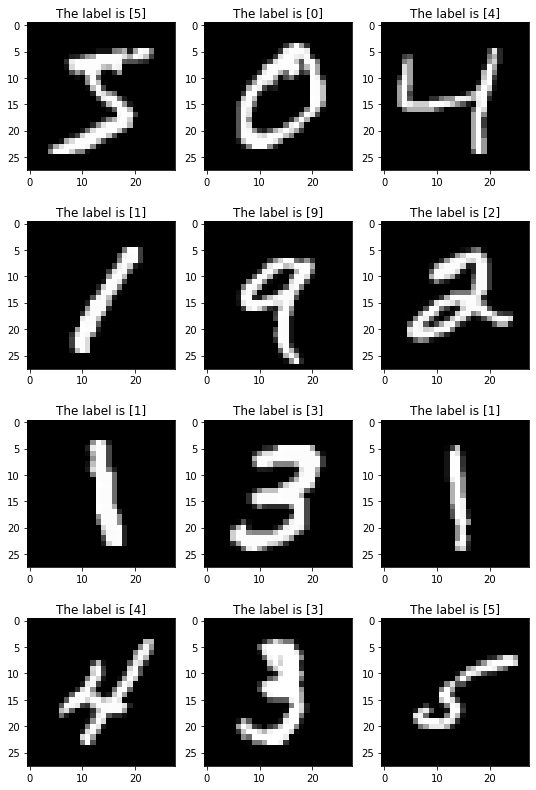

In [3]:
def show_images(images, labels):
    """
    Shows 12 random colored (RGB) images and the coresponding labels.
    If gray equals 'False' (default) then deplay gray images,
    else deplay colored images
    """
    nb_images=12
    columns = 3
    rows = 4
    fig = plt.figure(figsize=(9, 14))
    # ax enables access to manipulate each of subplots
    ax = []
    # Select randomly the indexes of the 12 images
    rnd_idx = random.sample(range(images.shape[0]), nb_images)
    for i in range(nb_images):
        i_img = rnd_idx[i] # index of the image that we will show
        # create subplot and append to ax
        ax.append( fig.add_subplot(rows, columns, i+1) )
        ax[-1].set_title(f'The label is {labels[i]}') # set title

        plt.imshow(images[i,:,:,0], cmap='gray')

    plt.show()
show_images(x_train, y_train)

In [4]:
# Create 3 callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.7,
                              patience=3,
                              verbose=1)
early_stopping = EarlyStopping(monitor='val_accuracy',
                               patience=6,
                               verbose=1)
checkpoint = ModelCheckpoint(filepath = 'checkpoint_cnn_best',
                             monitor='val_accuracy',
                             save_best_only=True,
                             save_weights_only=True,
                             verbose=1)

In [5]:
model = Sequential([
    Conv2D(20, (2,2),activation='relu', padding="same", input_shape=(28,28,1,)),
    MaxPool2D((2, 2)),
    Conv2D(15, (2,2), activation='relu', padding="same"),
    MaxPool2D((2, 2)),
    Flatten(),
    Dense(15, activation='relu'),
    Dropout(0.2),
    Dense(10, activation='softmax')
])

model.summary()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
hist = model.fit(x_train, y_train_ohe, epochs=500, verbose=1, validation_split=0.15, callbacks=[reduce_lr, early_stopping, checkpoint])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 20)        100       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 20)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 15)        1215      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 15)          0         
_________________________________________________________________
flatten (Flatten)            (None, 735)               0         
_________________________________________________________________
dense (Dense)                (None, 15)                11040     
_________________________________________________________________
dropout (Dropout)            (None, 15)                0

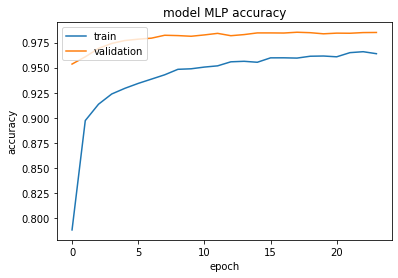

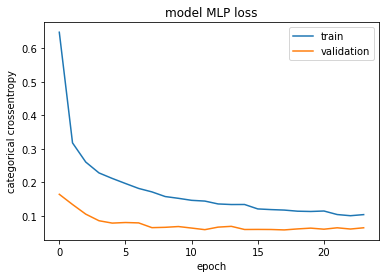

In [6]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model MLP accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model MLP loss')
plt.ylabel('categorical crossentropy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [7]:
model.load_weights('checkpoint_cnn_best')

In [8]:
evalu = model.evaluate(x_test, y_test_ohe, verbose=0)
print(f'Loss on the test set: {evalu[0]}')
print(f'Accuracy on the test set: {evalu[1]}')

Loss on the test set: 0.055740710347890854
Accuracy on the test set: 0.9843999743461609


In [16]:
images = []
labels = []
predictions = []
for i in range(0, 10):
    rdm_num = np.random.randint(x_test.shape[0], size=1)
    img_gray = x_test[rdm_num, :,:,:]
    images.append(img_gray)
    labels.append(str(y_test[rdm_num]).strip('[]'))
    predictions.append(model.predict(img_gray))

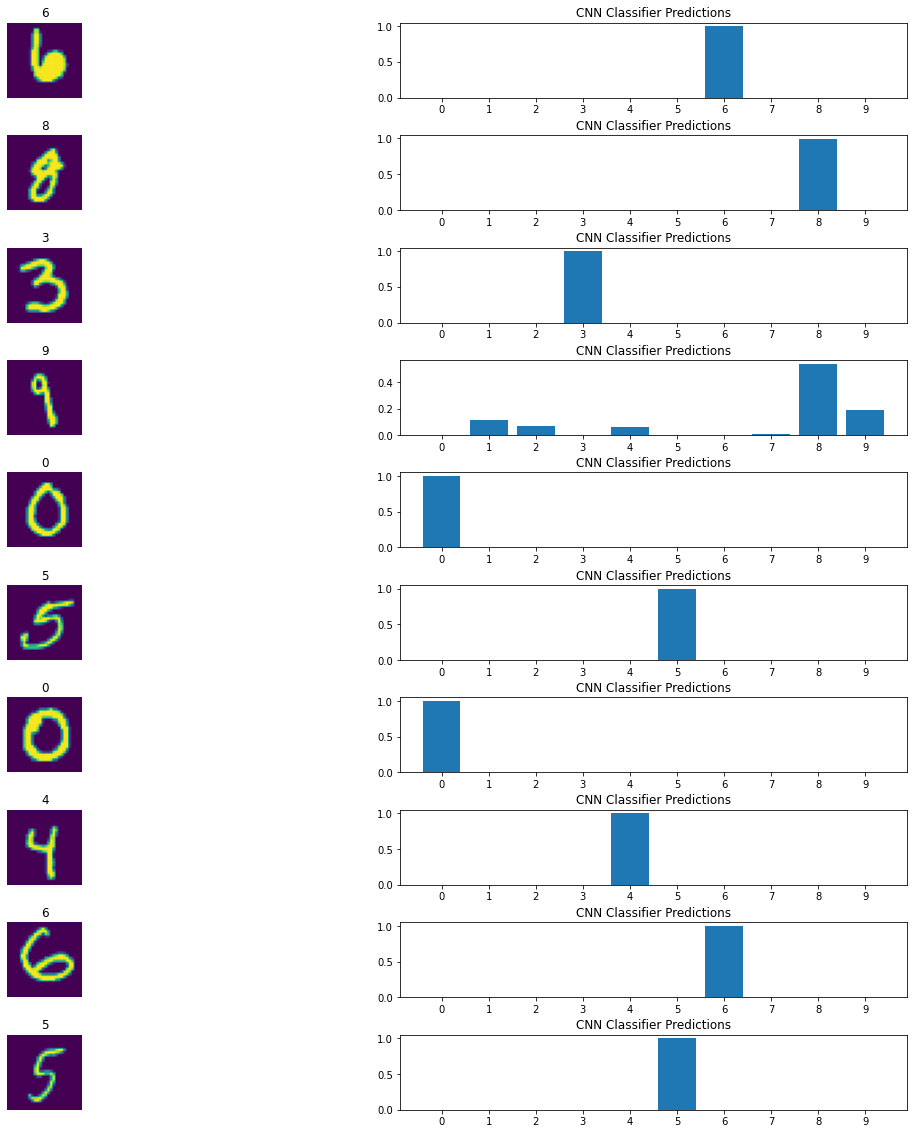

In [18]:
fig, axs = plt.subplots(nrows=10, ncols=2, figsize=(20,20))
fig.subplots_adjust(hspace=0.5, wspace=0.2)
x = np.arange(0,10)
for i, (image, label, prediction) in enumerate(zip(images, labels, predictions)):
    axs[i, 0].imshow(np.squeeze(image))
    axs[i, 0].set_title(label)
    axs[i, 0].axis('off')
    axs[i, 1].bar(x, prediction.reshape(10,))
    axs[i, 1].set_title('CNN Classifier Predictions')
    axs[i, 1].set_xticks(x)